### 偏差方差
偏差Bias:预测值和真实值的差距表示算法的拟合能力

方差Variance:预测值的变化范围表示数据扰动产生的影响

训练集Train:训练模型

验证集Validation:选择模型，模型的最终优化

测试集Test:测试模型泛化能力

案例：根据水位变化预测大坝出水量

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize

In [33]:
data=loadmat('ex5data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [34]:
X_train,y_train=data['X'],data['y']
X_train.shape,y_train.shape

((12, 1), (12, 1))

In [35]:
X_val,y_val=data['Xval'],data['yval']
X_val.shape,y_val.shape

((21, 1), (21, 1))

In [36]:
X_test,y_test=data['Xtest'],data['ytest']
X_test.shape,y_test.shape

((21, 1), (21, 1))

In [37]:
X_train=np.insert(X_train,0,1,axis=1)
X_val=np.insert(X_val,0,1,axis=1)
X_test=np.insert(X_test,0,1,axis=1)

In [38]:
def plot_data():
    fig,ax=plt.subplots()
    ax.scatter(X_train[:,1],y_train)
    ax.set(xlabel='change in water level(x)',ylabel='water flowing out og the dam(y)')

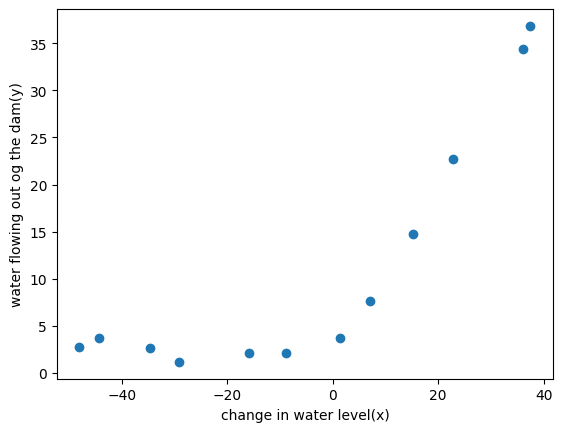

In [39]:
#画图
plot_data()

### 线性回归
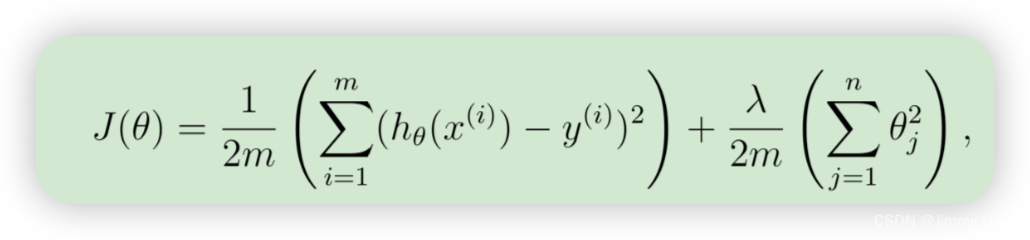

In [40]:
def reg_cost(theta,X,y,lamda):
    cost=np.sum(np.power(X@theta-y.flatten(),2))
    reg=theta[1:]@theta[1:]*lamda
    return (cost+reg)/2/len(X)

In [41]:
theta=np.ones(X_train.shape[1])
lamda=1
reg_cost(theta,X_train,y_train,lamda)

np.float64(303.9931922202643)

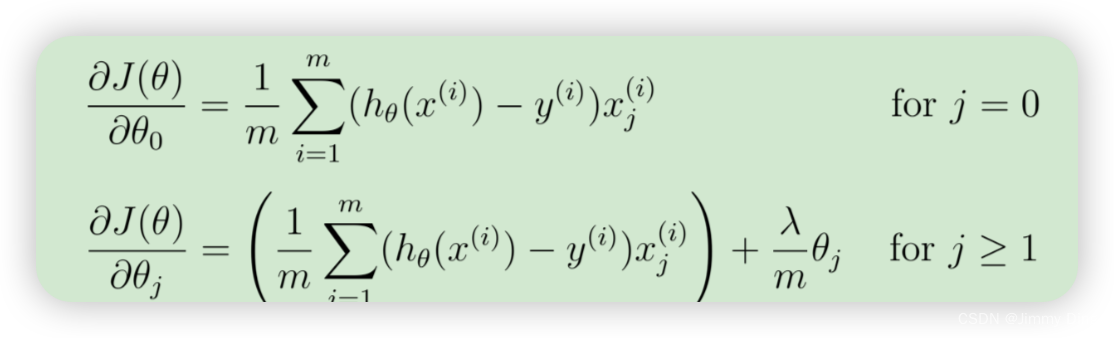

In [42]:
def reg_gradient(theta,X,y,lamda):
    grad=(X@theta-y.flatten())@X
    reg=lamda*theta
    reg[0]=0

    return (grad+reg)/len(X)

In [43]:
reg_gradient(theta,X_train,y_train,lamda)

array([-15.30301567, 598.25074417])

In [44]:
def train_model(X,y,lamda):
    theta=np.ones(X.shape[1])
    res=minimize(
        fun=reg_cost,
        x0=theta,
        args=(X,y,lamda),
        method='TNC',
        jac=reg_gradient
    )
    return res.x

In [45]:
theta_final=train_model(X_train,y_train,lamda=0)

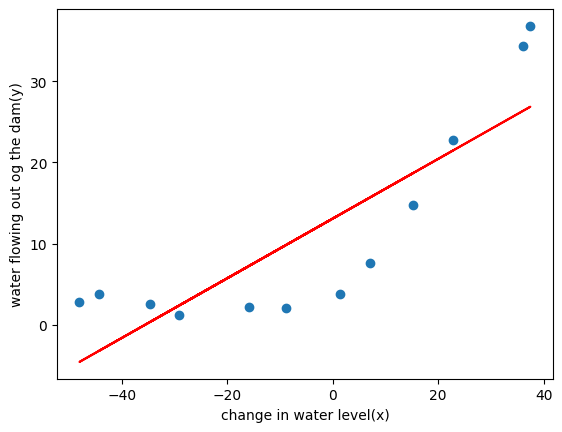

In [46]:
plot_data()
plt.plot(X_train[:,1],X_train@theta_final,c='r')
plt.show()

#### 任务：训练样本从1开始递增，比较训练集和验证集上的损失函数的变化情况

In [47]:
def plot_learning_curve(X_train,y_train,X_val,y_val,lamda):
    x=range(1,len(X_train)+1)
    training_cost=[]
    cv_cost=[]

    for i in x:
        res=train_model(X_train[:i,:],y_train[:i,:],lamda)

        training_cost_i=reg_cost(res,X_train[:i,:],y_train[:i,:],lamda)
        training_cost.append(training_cost_i)

        cv_cost_i=reg_cost(res,X_val,y_val,lamda)
        cv_cost.append(cv_cost_i)

    plt.plot(x,training_cost,label='traing cost')
    plt.plot(x,cv_cost,label='cv cost')
    plt.legend()
    plt.xlabel('number of training examples')
    plt.ylabel('error')
    plt.show()

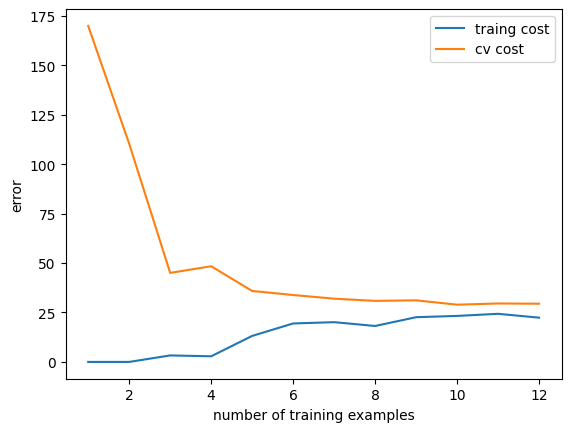

In [48]:
 plot_learning_curve(X_train,y_train,X_val,y_val,lamda=0)

总结：随着训练集数量增加，训练集的误差增加，验证集的误差减少。
-> 欠拟合模型-> 高偏差bias

### 构造多项式特征，进行多项式回归

In [49]:
def poly_feature(X,power):
    for i in range(2,power+1):
        X=np.insert(X,X.shape[1],np.power(X[:,1],i),axis=1)
    return X

In [50]:
# 归一化
# 获取均值
def get_means_stds(X):
    means=np.mean(X,axis=0)
    stds=np.std(X,axis=0)
    return means,stds

In [51]:
def feature_normalize(X,means,stds):
    # 第一列不作归一化
    X[:,1:]=(X[:,1:]-means[1:])/stds[1:]
    return X

In [52]:
power=6

In [53]:
X_train_poly=poly_feature(X_train,power)
X_val_poly=poly_feature(X_val,power)
X_test_poly=poly_feature(X_test,power)

In [54]:
train_means,train_stds=get_means_stds(X_train_poly)

In [55]:
X_train_norm=feature_normalize(X_train_poly,train_means,train_stds)
X_val_norm=feature_normalize(X_val_poly,train_means,train_stds)
X_test_norm=feature_normalize(X_test_poly,train_means,train_stds)

In [56]:
theta_fit=train_model(X_train_norm,y_train,lamda=0)

In [57]:
# 绘制拟合函数
def plot_poly_fit():
    plot_data()

    x=np.linspace(-60,60,100)
    xx=x.reshape(100,1)
    xx=np.insert(xx,0,1,axis=1)
    xx=poly_feature(xx,power)
    xx=feature_normalize(xx,train_means,train_stds)

    plt.plot(x,xx@theta_fit,'r--')

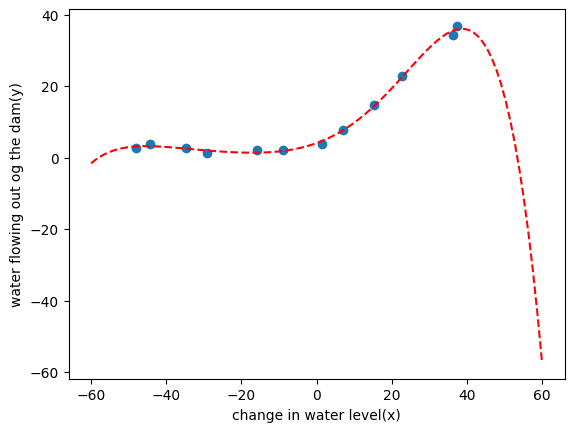

In [58]:
plot_poly_fit()

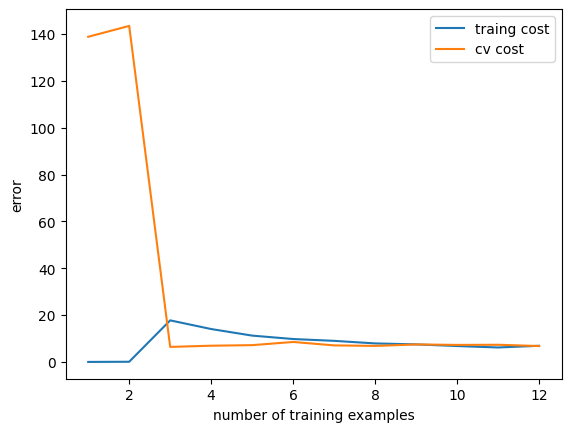

In [59]:
plot_learning_curve(X_train_norm,y_train,X_val_norm,y_val,lamda=1)

In [60]:
lamdas=[0,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]

training_cost=[]
cv_cost=[]

for lamda in lamdas:
    res=train_model(X_train_norm,y_train,lamda)

    tc=reg_cost(res,X_train_norm,y_train,lamda=0)
    cc=reg_cost(res,X_val_norm,y_val,lamda=0)

    training_cost.append(tc)
    cv_cost.append(cc)

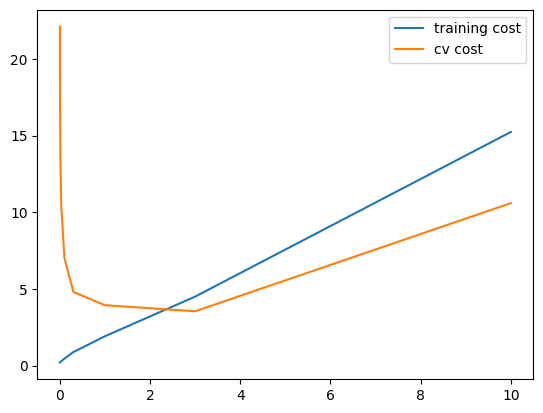

In [61]:
plt.plot(lamdas,training_cost,label='training cost')
plt.plot(lamdas,cv_cost,label='cv cost')
plt.legend()
plt.show()

In [62]:
lamdas[np.argmin(cv_cost)]

3

In [63]:
res=train_model(X_train_norm,y_train,lamda=3)
test_cost=reg_cost(res,X_test_norm,y_test,lamda=0)
print(test_cost)

4.397616235841964
